# Non Negative Matrix Factorization For SETI RFI Deletion

The problem with SETI searches is the Human Radio Frequency Interference (RFI) which can be confused as a positive for and ETI. Thus to remove the false positives we can preform a spatial filtering on the data samples. The following method shows a way to delete reoccuring signals within 2 consecutive frames.


In [0]:
!pip install setigen 
!pip install blimpy
%matplotlib inline

In [0]:
!wget http://blpd7.ssl.berkeley.edu/dl/GBT_57513_78094_HIP30112_mid.h5
!wget http://blpd7.ssl.berkeley.edu/dl/GBT_57513_78437_HIP29212_mid.h5

In [0]:
import pylab as plt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from random import seed
from random import random
from astropy import units as u
import setigen as stg
from blimpy import Waterfall



# Non Negative Matrix Factoring

The algorithm to preform the factoring is called a multiplicative update method (similar to gradient decent)where we iteratively update each value in the two matrices by a factor of the recreation matrix. A more detailed explanation can be found in the Original paper https://papers.nips.cc/paper/1861-algorithms-for-non-negative-matrix-factorization.pdf

In [0]:
def random_initialization(A,rank):
    number_of_documents = A.shape[0]
    number_of_terms = A.shape[1]
    W = np.random.uniform(1,2,(number_of_documents,rank))
    H = np.random.uniform(1,2,(rank,number_of_terms))
    return W,H
                          

def nndsvd_initialization(A,rank):
    u,s,v=np.linalg.svd(A,full_matrices=False)
    v=v.T
    w=np.zeros((A.shape[0],rank))
    h=np.zeros((rank,A.shape[1]))

    w[:,0]=np.sqrt(s[0])*np.abs(u[:,0])
    h[0,:]=np.sqrt(s[0])*np.abs(v[:,0].T)

    for i in range(1,rank):
        
        ui=u[:,i]
        vi=v[:,i]
        ui_pos=(ui>=0)*ui
        ui_neg=(ui<0)*-ui
        vi_pos=(vi>=0)*vi
        vi_neg=(vi<0)*-vi
        
        ui_pos_norm=np.linalg.norm(ui_pos,2)
        ui_neg_norm=np.linalg.norm(ui_neg,2)
        vi_pos_norm=np.linalg.norm(vi_pos,2)
        vi_neg_norm=np.linalg.norm(vi_neg,2)
        
        norm_pos=ui_pos_norm*vi_pos_norm
        norm_neg=ui_neg_norm*vi_neg_norm
        
        if norm_pos>=norm_neg:
            w[:,i]=np.sqrt(s[i]*norm_pos)/ui_pos_norm*ui_pos
            h[i,:]=np.sqrt(s[i]*norm_pos)/vi_pos_norm*vi_pos.T
        else:
            w[:,i]=np.sqrt(s[i]*norm_neg)/ui_neg_norm*ui_neg
            h[i,:]=np.sqrt(s[i]*norm_neg)/vi_neg_norm*vi_neg.T

    return w,h
def mu_method(A,k,W,H,max_iter,init_mode='random'):
    e = 1.0e-10
    for n in range(max_iter):
        # Update H
        W_TA = W.T@A
        W_TWH = W.T@W@H+e
        for i in range(np.size(H, 0)):
            for j in range(np.size(H, 1)):
                H[i, j] = H[i, j] * W_TA[i, j] / W_TWH[i, j]
        # Update W
        AH_T = A@H.T
        WHH_T =  W@H@H.T+ e

        for i in range(np.size(W, 0)):
            for j in range(np.size(W, 1)):
                W[i, j] = W[i, j] * AH_T[i, j] / WHH_T[i, j]
        norm = np.linalg.norm(A - W@H, 'fro')
        if n%30==0:
          print("Update Loss -- "+str(n)+" ---- "+str(norm))
        
    return W ,H 


# Loading Data 
Next we load the data and inject a signal into the waterfall plot. The index chosen for this plot is at 1394mHz where there is known RFI signals. Starting at 129540. The Y axis is tchans and X axis is fchans

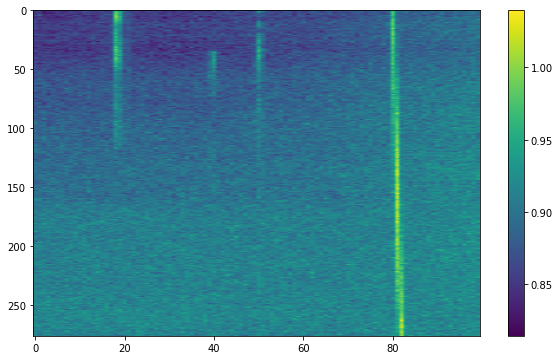

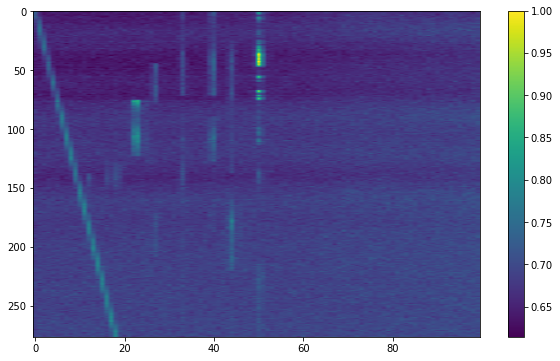

In [0]:
starting = 129540
obsA = Waterfall("/content/GBT_57513_78094_HIP30112_mid.h5")
A =obsA.data[:,0,starting:starting+100]
A = A/A.max()
frameA = stg.Frame(fchans=A.shape[1]*u.pixel,
                    tchans=A.shape[0]*u.pixel,
                    df=2.7939677238464355*u.Hz,
                    dt=18.25361108*u.s,
                    fch1=6095.214842353016*u.MHz,
                    data = A)
frameA.add_signal(stg.constant_path(f_start=frameA.get_frequency(80),
                                    drift_rate=0.001*u.Hz/u.s),
                  stg.constant_t_profile(level=1),
                  stg.gaussian_f_profile(width=3*u.Hz),
                  stg.constant_bp_profile(level=0.1))
A = frameA.get_data()

obsB =  Waterfall("/content/GBT_57513_78437_HIP29212_mid.h5")
B = obsB.data[:,0,starting:starting+100]
B= B/B.max()
frameB = stg.Frame(fchans=A.shape[1]*u.pixel,
                    tchans=A.shape[0]*u.pixel,
                    df=2.7939677238464355*u.Hz,
                    dt=18.25361108*u.s,
                    fch1=6095.214842353016*u.MHz,
                    data = B)
frameB.add_signal(stg.constant_path(f_start=frameB.get_frequency(0),
                                    drift_rate=0.01*u.Hz/u.s),
                  stg.constant_t_profile(level=1),
                  stg.gaussian_f_profile(width=3*u.Hz),
                  stg.constant_bp_profile(level=0.1))
B = frameB.get_data()


%matplotlib inline
fig = plt.figure(figsize=(10, 6))
plt.imshow(A, aspect='auto')
plt.colorbar()
fig = plt.figure(figsize=(10, 6))
plt.imshow(B, aspect='auto')
plt.colorbar()

# Training 
Here we train the algorithm to create the matrices that multiply to give the original matrix. However notice the intialization of the H matrix for the second training block is different. 

The goal is the force the feature selection to recreate features that are present in both signals of A and of B. 

In [0]:
import numpy as np
from copy import deepcopy
k = int(A.shape[0]/2)
W, H = random_initialization(A,k)
W_copy = deepcopy(W)
H_copy = deepcopy(H)
print("Training A")
W_A, H_A =  mu_method(A,k=k,max_iter=400,W=W,H=H, init_mode='random')

print("Training B")

W_B, H_B =  mu_method(B,k=k,max_iter=400,W=W_copy,H=H,init_mode='random')

Training A
Update Loss -- 0 ---- 2.477161546082223
Update Loss -- 30 ---- 2.4383261798016522
Update Loss -- 60 ---- 2.3990615740229537
Update Loss -- 90 ---- 2.3561159031321726
Update Loss -- 120 ---- 2.3062267995115646
Update Loss -- 150 ---- 2.2463230973367936
Update Loss -- 180 ---- 2.1746599700579874
Update Loss -- 210 ---- 2.0926719286820368
Update Loss -- 240 ---- 2.0062352628759568
Update Loss -- 270 ---- 1.9240745062244844
Update Loss -- 300 ---- 1.8531732846476774
Update Loss -- 330 ---- 1.7952671704461796
Update Loss -- 360 ---- 1.7477439410826423
Update Loss -- 390 ---- 1.7068462060746286
Training B
Update Loss -- 0 ---- 2.732057433376906
Update Loss -- 30 ---- 2.6647798712341575
Update Loss -- 60 ---- 2.5860802744603455
Update Loss -- 90 ---- 2.478397608008779
Update Loss -- 120 ---- 2.3323376018264996
Update Loss -- 150 ---- 2.176314586048801
Update Loss -- 180 ---- 2.051653718158153
Update Loss -- 210 ---- 1.9454116681678608
Update Loss -- 240 ---- 1.8436542361858845
Upda

# Generating Template
We can then generate the template full of RFI and subtract that template from the original scan of A or of B! This undoubtly affect all signals.

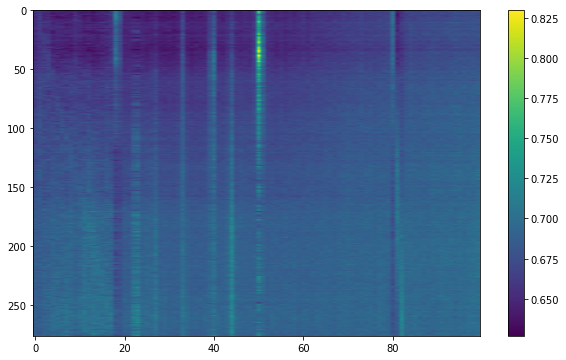

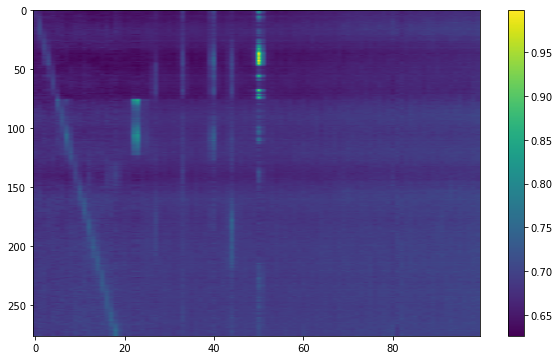

In [0]:
OG_A = W_A@ H_A
OG_B = W_B@ H_B
fig = plt.figure(figsize=(10, 6))
plt.imshow(OG_A, aspect='auto')
plt.colorbar()
fig = plt.figure(figsize=(10, 6))
plt.imshow(OG_B, aspect='auto')
plt.colorbar()

# Result 
Now we can see when we element wise subtract the signal out of the original scan we can get a "cleaner" scan of just the "transient" signal. 

In [0]:
# Functions used to prevent negative value of intensities. It fills
# negative values with a random value guassian distributed. 
def zero_out(arr):
  for i in range(arr.shape[0]):
    for k in range(arr.shape[1]):
      if arr[i,k]<0:
        arr[i,k]=0
  return arr

def random_out(arr):
  for i in range(arr.shape[0]):
    for k in range(arr.shape[1]):
      if arr[i,k]<0.1:
        arr[i,k]=random()*0.05
  return arr

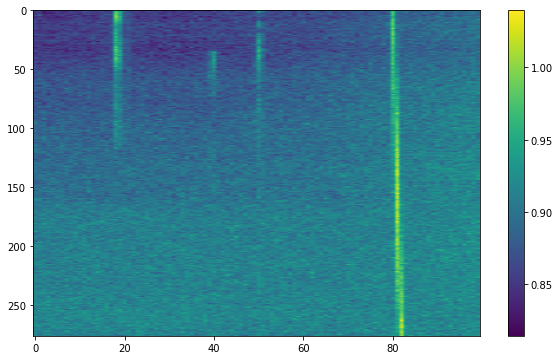

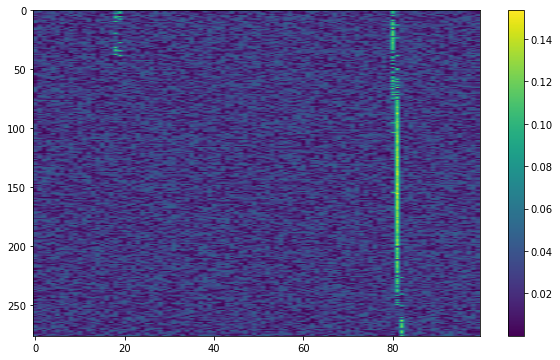

In [0]:
tune = 1
back = W_A@H_A
fig = plt.figure(figsize=(10, 6))
plt.imshow(A, aspect='auto')
plt.colorbar()

back = back *(A.max()/back.max())
result = A - back*tune 
result = random_out(result)

fig = plt.figure(figsize=(10, 6))
plt.imshow(result, aspect='auto')
plt.colorbar()